## Preambule

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import plotly.express as px
from plotly.colors import n_colors
from plotly.subplots import make_subplots
import os
import matplotlib as mpl
from pathlib import Path
import matplotlib.pyplot as plt
from datetime import date
import plotly.graph_objects as go
from Plotfunctions import draw_line

## Parameters

In [2]:
save = 0                                # Save the figure or not

In [3]:
varvector = [
             ['Final Energy|Transportation|Liquids|Bioenergy', 'forestgreen'],
             ['Final Energy|Transportation|Liquids|Oil', 'tomato'],
             ['Final Energy|Transportation|Hydrogen', 'steelblue'],
             ['Final Energy|Transportation|Electricity', 'goldenrod'],
            ]
varvector = np.array(varvector)
cols = varvector[:, 1]
Variables = varvector[:, 0]

## Paths

In [4]:
current_dir = Path.cwd()
path_ipcc = Path("../../../Data/IPCC/") # Location of IPCC data
path_meta = path_ipcc / "AR6_Scenarios_Database_metadata_indicators_v1.1.xlsx"
path_data = current_dir / "../Data"
path_ar6 = path_ipcc / "AR6_Scenarios_Database_World_v1.1.csv"
path_modelconv = path_ipcc / "ModelConversion.xlsx"

## Prereading stuff

In [5]:
try:
    XRvar.close()
except:
    3
XRvar = xr.open_dataset(path_data / "Output_files" / "Variances.nc")
Varlist = pd.read_excel(path_data / "Input_files" / "Varlist.xlsx", sheet_name = "Data")
vars = np.array(Varlist["Variable"])
cats = np.array(Varlist["Category"])
Names = np.unique(cats)
XRraw = xr.open_dataset(path_data / "Handling_files" / "XRdata.nc")
XRmeta = xr.open_dataset(path_data / "Handling_files" / "XRmeta.nc")
XRdata = XRraw
DF = pd.read_csv(path_data / "Handling_files" / "Models.csv")
values = np.array(XRraw.Value)
modscens = np.array(XRraw.ModelScenario)
mods = np.array([i.split('|')[0] for i in modscens])
ccat = np.array(XRmeta.sel(ModelScenario=XRraw.ModelScenario).Category.data)
unimods = np.unique(mods)
uniccat = np.unique(ccat)
DF_counts = pd.read_csv(path_data / "Handling_files" / "Counts.csv", index_col=0)
XRvar = XRvar.sel(Time=range(2030,2101))
varlist = XRvar.Variable.data
years = XRvar.Time.data
years_str = np.copy(years).astype(str)
years_str[(years_str != '2050') & (years_str != '2100')] = ''

## Create traces

In [6]:
def rescale_size(s, max):
    s /= max
    # s *= 1e11
    s = s ** 0.8
    return s

A few parameters

In [7]:
scale = 100

Actual traces

In [10]:
def rgb_toint(col, alpha):
    nums = np.array(col[4:-1].split(',')).astype(float).astype(int)
    return "rgba("+str(nums[0])+','+str(nums[1])+','+str(nums[2])+','+str(alpha)+')'
    
xrsub = XRvar.sel(Variable = Variables, Time = np.arange(2030, 2101, 1))
varmax = np.max(XRvar['CoefVar']).data
varlist = np.array(xrsub.Variable)
names = []
for v_i in range(len(varlist)):
        if varlist[v_i] == 'Final Energy|Transportation':
                names.append('Total')
        elif varlist[v_i] == 'Final Energy|Transportation|Liquids|Oil':
                names.append('Oil')
        elif varlist[v_i] == 'Final Energy|Transportation|Liquids|Bioenergy':
                names.append('Bioenergy')
        else:
                names.append(varlist[v_i][28:])
years = XRvar.Time.data

years_str = np.copy(years).astype(str)
years_str[(years_str != '2050') & (years_str != '2100')] = ''

Line and star traces

In [11]:
linetraces = []
startraces = []

In [12]:
lw = 5
timeaxis = [2030, 2050, 2100]
# FULL LINES
for v in range(len(varlist)):
    try:
            count = list(DF_counts[DF_counts.Variable==varlist[v]].Count)[0]
    except:
            count = "-"
    ds = xrsub.sel(Variable=varlist[v], Time=timeaxis) #np.arange(2030, 2101, 5))
    a, b, c, d, s = np.array(ds[['S_c', 'S_m', 'S_z', 'S_mc', 'CoefVar']].to_array())
    s = scale*rescale_size(s, varmax)
    rgb = mpl.colors.colorConverter.to_rgb(cols[v])
    colly='rgb('+str(rgb[0]*255)+','+str(rgb[1]*255)+','+str(rgb[2]*255)+')'
    colly_white = 'rgb('+str(rgb[0]*255*1.3)+','+str(rgb[1]*255*1.3)+','+str(rgb[2]*255*1.3)+')'
    colrow = n_colors('rgb(0,0,0)', colly, int(len(a)/2+2), colortype='rgb') + n_colors(colly, 'rgb(255, 255, 255)', int(len(a)/2+4), colortype='rgb')

    trace = go.Scatterternary(a=a+0.5*d, b=b+0.5*d, c=c,
                                mode='lines',
                                name=names[v],#+' ('+str(count)+')',
                                showlegend=False, #([False]*int(len(a)/2)+[True]+[False]*99)[i],
                                text=timeaxis, #np.arange(2030, 2101, 5),
                                hovertemplate='%{text}<br>Var (climate): %{a}<br>Var (model): %{b} <br>Var (other): %{c}',
                                line={'width': lw, #np.mean(s[i:i+2])*0.5,
                                        'color': cols[v]})
    linetraces.append(trace)

sz = 32
# MARKERS TOPLAYER
for v in range(len(varlist)):
    try:
            count = list(DF_counts[DF_counts.Variable==varlist[v]].Count)[0]
    except:
            count = "-"
    ds = xrsub.sel(Variable=varlist[v], Time=timeaxis)
    a, b, c, d, s = np.array(ds[['S_c', 'S_m', 'S_z', 'S_mc', 'CoefVar']].to_array())
    s = scale*rescale_size(s, varmax)
    rgb = mpl.colors.colorConverter.to_rgb(cols[v])
    colly='rgb('+str(rgb[0]*255)+','+str(rgb[1]*255)+','+str(rgb[2]*255)+')'
    colly_white = 'rgb('+str(rgb[0]*255*1.3)+','+str(rgb[1]*255*1.3)+','+str(rgb[2]*255*1.3)+')'
    colrow = n_colors('rgb(0,0,0)', colly, int(len(a)/2+2), colortype='rgb') + n_colors(colly, 'rgb(255, 255, 255)', int(len(a)/2+4), colortype='rgb')

    k=0
    for i in range(len(a)-1):
        cl1 = rgb_toint(colrow[i+2], 1)#0.9-i*0.03)
        cl = rgb_toint(colrow[i+2], 1)#1-i*0.03)
        trace = go.Scatterternary(a=a[i:i+2]+0.5*d[i:i+2], b=b[i:i+2]+0.5*d[i:i+2], c=c[i:i+2],
                                        mode='markers+text',
                                        name=names[v],#+' ('+str(count)+')',
                                        showlegend=False, #([False]*int(len(a)/2)+[True]+[False]*99)[i],
                                        text=[[timeaxis[i], ''], [timeaxis[i], timeaxis[i+1]], [timeaxis[i], timeaxis[i+1]], [timeaxis[i], timeaxis[i+1]], [timeaxis[i], timeaxis[i+1]], [timeaxis[i], timeaxis[i+1]], [timeaxis[i], timeaxis[i+1]], [timeaxis[i], timeaxis[i+1]], [timeaxis[i], timeaxis[i+1]], [timeaxis[i], timeaxis[i+1]], [timeaxis[i], timeaxis[i+1]], [timeaxis[i], timeaxis[i+1]]][k],
                                        hovertemplate='%{text}<br>Var (climate): %{a}<br>Var (model): %{b} <br>Var (other): %{c}',
                                        marker={'size': [[sz, 0], [sz, sz], [sz, sz], [sz, sz], [sz, sz], [sz, sz], [sz, sz], [sz, sz], [sz, sz], [sz, sz], [sz, sz], [sz, sz], [sz, sz], [sz, sz], [sz, sz], [sz, sz]][k],#s[i:i+2]*0.45, !!!!!!!!!!!!!!!!! VARIANCE !!!!!!!!!!!!!!!!!!!!
                                                'color': cols[v],
                                                'opacity': 1,#0.9-i*0.03,
                                                'line' :dict(width=1, color="black")},
                                        line={'width': lw, #np.mean(s[i:i+2])*0.5,
                                                'color': cols[v]},
                                        textfont=dict(size=11,
                                                family='Arial Black',
                                                color="black"))
        linetraces.append(trace)
        k+=1

In [13]:
# Stars

for v in range(len(varlist)):
    try:
            count = list(DF_counts[DF_counts.Variable==varlist[v]].Count)[0]
    except:
            count = "-"
    ds = xrsub.sel(Variable=varlist[v], Time=np.arange(2030, 2101, 5))
    a, b, c, d, s = np.array(ds[['S_c', 'S_m', 'S_z', 'S_mc', 'CoefVar']].to_array())
    s = scale*rescale_size(s, varmax)
    rgb = mpl.colors.colorConverter.to_rgb(cols[v])
    colly='rgb('+str(rgb[0]*255)+','+str(rgb[1]*255)+','+str(rgb[2]*255)+')'
    colly_white = 'rgb('+str(rgb[0]*255*1.3)+','+str(rgb[1]*255*1.3)+','+str(rgb[2]*255*1.3)+')'
    colrow = n_colors('rgb(0,0,0)', colly, int(len(a)/2+5), colortype='rgb') + n_colors(colly, 'rgb(255, 255, 255)', int(len(a)/2+5), colortype='rgb')

    for i in range(len(a)-1):
        if np.arange(2030, 2101, 5)[i] == 2050:
                cl1 = rgb_toint(colrow[i+2], 1)#0.9-i*0.03)
                cl = rgb_toint(colrow[i+2], 1)#1-i*0.03)
                trace = go.Scatterternary(a=a[i:i+1]+0.5*d[i:i+1], b=b[i:i+1]+0.5*d[i:i+1], c=c[i:i+1],
                                                mode='markers',
                                                name=names[v]+' ('+str(count)+')',
                                                showlegend=False, text=np.arange(2030, 2101, 5)[i:i+1],
                                                hovertemplate='%{text}<br>Var (climate): %{a}<br>Var (model): %{b} <br>Var (other): %{c}',
                                                marker={'size': 4,
                                                        'color': cl1,
                                                        'symbol': 'x-thin',
                                                        'opacity': 1,#0.9-i*0.03,
                                                        'line' :dict(width=15, color='black')},#dict(width=s[i:i+1]*0.45/5+1
                                                line={'width': 1.5,
                                                        'color': cl},
                                                textfont=dict(size=1,
                                                        color=cl))
                startraces.append(trace)
                cl1 = rgb_toint(colrow[i+2], 1)#0.9-i*0.03)
                cl = rgb_toint(colrow[i+2], 1)#1-i*0.03)
                trace = go.Scatterternary(a=a[i:i+1]+0.5*d[i:i+1], b=b[i:i+1]+0.5*d[i:i+1], c=c[i:i+1],
                                                mode='markers',
                                                name=names[v]+' ('+str(count)+')',
                                                showlegend=False, text=np.arange(2030, 2101, 5)[i:i+1],
                                                hovertemplate='%{text}<br>Var (climate): %{a}<br>Var (model): %{b} <br>Var (other): %{c}',
                                                marker={'size': 2, #s[i:i+1]*0.45,
                                                        'color': cl1,
                                                        'symbol': 'x-thin',
                                                        'opacity': 1,#0.9-i*0.03,
                                                        'line' :dict(width=10, color=cols[v])},
                                                line={'width': 1.5,
                                                        'color': cl},
                                                textfont=dict(size=1,
                                                        color=cl))
                startraces.append(trace)

In [14]:
from Plotfunctions import rescale_size, draw_line, boxplots

In [16]:
T1 = boxplots("Final Energy|Transportation|Liquids|Oil", 'tomato', 2050, XRdata, XRmeta, "cat",
              "", "yes")
T2 = boxplots("Final Energy|Transportation|Electricity", 'goldenrod', 2050, XRdata, XRmeta, "model",
              "", "yes")
T4 = boxplots("Final Energy|Transportation|Hydrogen", 'steelblue', 2050, XRdata, XRmeta, "model",
              "", "yes")
# T3 = boxplots("Final Energy|Transportation|Gases", 'grey', 2050, XRdata, XRmeta, "cat",
#               "Variance in <b>gas</b> energy use in transport<br>is dominated by other signals than climate outcome", "yes")
T3 = boxplots("Final Energy|Transportation|Liquids|Bioenergy", 'forestgreen', 2050, XRdata, XRmeta, "model",
              "", "yes")

y1, t1, title1, col1 = T1
y2, t2, title2, col2 = T2
y3, t3, title3, col3 = T3
y4, t4, title4, col4 = T4

Ternary plot

In [17]:
trace_ternary_lines = []
for i in range(10):
        a = [0+i*0.1, 0+i*0.1]
        b = [0, 1-a[0]]
        c = [1-a[0], 0]
        rgb = mpl.colors.colorConverter.to_rgb(plt.cm.get_cmap('Greys')(0.+i/20))
        col = 'rgb('+str(rgb[0])+','+str(rgb[1])+','+str(rgb[2])+')'
        trace_ternary_lines.append(go.Scatterternary(a=a, b=b, c=c, showlegend=False, mode='lines', hoverinfo='skip', line={'width': 0.25+i*0.1, 'color': col}))
        trace_ternary_lines.append(go.Scatterternary(a=b, b=a, c=c, showlegend=False, mode='lines', hoverinfo='skip', line={'width': 0.25+i*0.1, 'color': col}))
        trace_ternary_lines.append(go.Scatterternary(a=b, b=c, c=a, showlegend=False, mode='lines', hoverinfo='skip', line={'width': 0.25+i*0.1, 'color': col}))

trace_ternary_border = []

C:\Users\dekkerm\AppData\Local\Temp\2\ipykernel_4424\4024270652.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  rgb = mpl.colors.colorConverter.to_rgb(plt.cm.get_cmap('Greys')(0.+i/20))


## Contours / background

In [18]:
def clean_data(data_in):
    """
    Cleans data in a format which can be conveniently
    used for drawing traces. Takes a dictionary as the
    input, and returns a list in the following format:

    input = {'key': ['a b c']}
    output = [key, [a, b, c]]
    """
    key = list(data_in.keys())[0]
    data_out = [key]
    for i in data_in[key]:
        data_out.append(list(map(float, i.split(' '))))

    return data_out

In [19]:
conts = []
for i in np.arange(35, 51, 5):
    conts.append({str(i): [str(i) +' '+str(i)+' '+str(100-2*i),
                  str(i) +' '+str(100-2*i)+' '+str(i),
                  str(100-2*i) +' '+str(i)+' '+str(i)]})
for i in np.arange(55, 101, 5):
    i0 = str(i)
    i1 = str(100-i)
    conts.append({str(i): [i0+' '+i1+' 0',
                            i0+' 0 '+i1,
                            i1+' 0 '+i0,
                            '0 '+i1+' '+i0,
                            '0 '+i0+' '+i1,
                            i1+' '+i0+' 0',
                            i0+' '+i1+' 0']})

In [20]:
conts2 = []
for i in np.arange(35, 51, 5):
    conts2.append({str(i): [str(i) +' '+str(i)+' '+str(100-2*i),
                  str(i) +' '+str(100-2*i)+' '+str(i),
                  str(100-2*i) +' '+str(i)+' '+str(i)]})
for x in np.arange(55, 101, 5):
    conts2.append({str(i): [str(x)+' '+'0'+' '+str(100-x),
                               str(x-5)+' '+'0'+' '+str(100-(x-5)),
                               str(x-5)+' '+str(100-(x-5))+' '+'0',
                               str(x)+' '+str(100-x)+' '+'0',
                               str(x)+' '+'0'+' '+str(100-x)
                                ]})
    conts2.append({str(i): ['0'+' '+str(100-x)+' '+str(x),
                               '0'+' '+str(100-(x-5))+' '+str(x-5),
                               str(100-(x-5))+' '+'0'+' '+str(x-5),
                               str(100-x)+' '+'0'+' '+str(x),
                               '0'+' '+str(100-x)+' '+str(x)
                                ]})
    conts2.append({str(i): [str(100-x)+' '+str(x)+' '+'0',
                               str(100-(x-5))+' '+str(x-5)+' '+'0',
                               '0'+' '+str(x-5)+' '+str(100-(x-5)),
                               '0'+' '+str(x)+' '+str(100-x),
                               str(100-x)+' '+str(x)+' '+'0'
                                ]})

In [21]:
bar = px.colors.sequential.Greys # px.colors.diverging.RdBu_r
#bar = bar[2:-2]
#bar = bar[int(len(bar)/2)-2:]
colors = []
for i in range(len(bar)-1):
    colors = colors+n_colors(bar[i], bar[i+1], int(200/len(bar)), colortype='rgb')
colors = colors+n_colors(bar[i+1], bar[i+1], int(200/len(bar)), colortype='rgb')

In [22]:
conttraces = []
n = 0
for raw_data in conts2:
    data = clean_data(raw_data)

    a = [inner_data[0] for inner_data in data[1:]]
    a.append(data[1][0]) # Closing the loop

    b = [inner_data[1] for inner_data in data[1:]]
    b.append(data[1][1]) # Closing the loop

    c = [inner_data[2] for inner_data in data[1:]]
    c.append(data[1][2]) # Closing the loop

    conttraces.append(go.Scatterternary(
        text = data[0],
        a=a, b=b, c=c, mode='lines',
        line=dict(color='black', width=0),
        fill='toself',showlegend=False, hoverinfo='skip', opacity=0.2, 
        fillcolor = colors[int(200/len(conts2)*n)]#colors_iterator.__next__()
    ))
    n+=1
conttraces = conttraces[::-1]

## Add together

In [23]:
def draw_line(fig, name, x, y, xt, yt, color):
    fig.add_shape(type="line", xref='paper', yref='paper',
                  x0=x,
                  y0=x+xt,
                  x1=x,
                  y1=y+yt,
                  line=dict(color=color, width=3))
    fig.add_annotation(xref='paper',
                       yref='paper',
                       #xref = 'x4',
                       #yref = 'y4',
                       x=x,
                       ax=xt,
                       align="center",
                       y=y,
                       ay=yt,
                       text=name,
                       #textangle=90,
                       font=dict(color=color,
                                 family='Arial Black',
                                 size=12),
                       showarrow=True)

In [24]:
# Labels
def labels(fig):
    dy = 0.02
    fig.add_annotation(xref='paper',
                       yref='paper',
                       x=0.015,
                       ax=0,
                       align='center',
                       y=0.87,
                       ay=-0,
                       text='(a) Decomposition',
                       font=dict(color='black', family='Arial Black', size=18),
                       showarrow=False)

    y = 0.87
    x = 0.75
    fig.add_annotation(xref='paper',
                       yref='paper',
                       x=x,
                       ax=0,
                       align='left',
                       y=y,
                       ay=-0,
                       text='(b) Oil',
                       font=dict(color='black', family='Arial Black', size=18),
                       showarrow=False)
    fig.add_annotation(xref='paper',
                       yref='paper',
                       x=x+0.04,
                       ax=0,
                       align='left',
                       y=y-dy-0.005,
                       ay=-0,
                       text='(2050, EJ)',
                       font=dict(color='black', family='Arial Black', size=14),
                       showarrow=False)

    y = 0.525
    x = 0.82
    fig.add_annotation(xref='paper',
                       yref='paper',
                       x=x,
                       ax=0,
                       align='left',
                       y=y,
                       ay=-0,
                       text='(c) Electricity',
                       font=dict(color='black', family='Arial Black', size=18),
                       showarrow=False)
    fig.add_annotation(xref='paper',
                       yref='paper',
                       x=x-0.01,
                       ax=0,
                       align='left',
                       y=y-dy,
                       ay=-0,
                       text='(2050, EJ)',
                       font=dict(color='black', family='Arial Black', size=14),
                       showarrow=False)

    y = 0.16
    x = 0.015
    fig.add_annotation(xref='paper',
                       yref='paper',
                       x=x,
                       ax=0,
                       align='left',
                       y=y,
                       ay=-0,
                       text='(d) Biofuels (liquid)',
                       font=dict(color='black', family='Arial Black', size=18),
                       showarrow=False)
    fig.add_annotation(xref='paper',
                       yref='paper',
                       x=x+0.03,
                       ax=0,
                       align='left',
                       y=y-dy,
                       ay=-0,
                       text='(2050, EJ)',
                       font=dict(color='black', family='Arial Black', size=14),
                       showarrow=False)

    y = 0.16
    x = 0.42
    fig.add_annotation(xref='paper',
                       yref='paper',
                       x=x,
                       ax=0,
                       align='left',
                       y=y,
                       ay=-0,
                       text='(e) Hydrogen',
                       font=dict(color='black', family='Arial Black', size=18),
                       showarrow=False)
    fig.add_annotation(xref='paper',
                       yref='paper',
                       x=x,
                       ax=0,
                       align='left',
                       y=y-dy,
                       ay=-0,
                       text='(2050, EJ)',
                       font=dict(color='black', family='Arial Black', size=14),
                       showarrow=False)

In [25]:
def linshape(col, x0, y0, x1, y1, type='solid'):
    fig.add_shape(type="line", xref='paper', yref='paper',
                    x0=x0,
                    y0=y0,
                    x1=x1,
                    y1=y1,
                    line=dict(color=col, width=3, dash=type))

def draw_lines(fig):
    x0=0.185
    dx=0.065
    y0 = 0.24
    linshape('forestgreen', (x0+x0+dx)/2, y0+0.01, 0.17, 0.465, type='dot')
    linshape('forestgreen', x0, y0+0.01, x0+dx,y0+0.01)
    linshape('forestgreen', x0, y0, x0, y0+0.01)
    linshape('forestgreen', x0+dx, y0, x0+dx, y0+0.01)
    
    x0=0.450
    dx=0.061
    linshape('steelblue', (x0+x0+dx)/2, 0.26, 0.325, 0.455, type='dot')
    linshape('steelblue', x0, y0+0.01, x0+dx, y0+0.01)
    linshape('steelblue', x0, y0, x0, y0+0.01)
    linshape('steelblue', x0+dx, y0, x0+dx, y0+0.01)
    
    x0 = 0.71
    y0 = 0.55
    linshape('goldenrod', x0, 0.58, 0.213, 0.495, type='dot')
    linshape('goldenrod', x0, y0+0.04, x0, y0)
    linshape('goldenrod', x0, y0+0.04, x0+0.01, y0+0.04)
    linshape('goldenrod', x0, y0, x0+0.01, y0)
    
    x0 = 0.722
    linshape('saddlebrown', x0, 0.91, 0.272, 0.685, type='dot')
    linshape('saddlebrown', x0, 0.93, x0, 0.89)
    linshape('saddlebrown', x0, 0.93, x0+0.01, 0.93)
    linshape('saddlebrown', x0, 0.89, x0+0.01, 0.89)

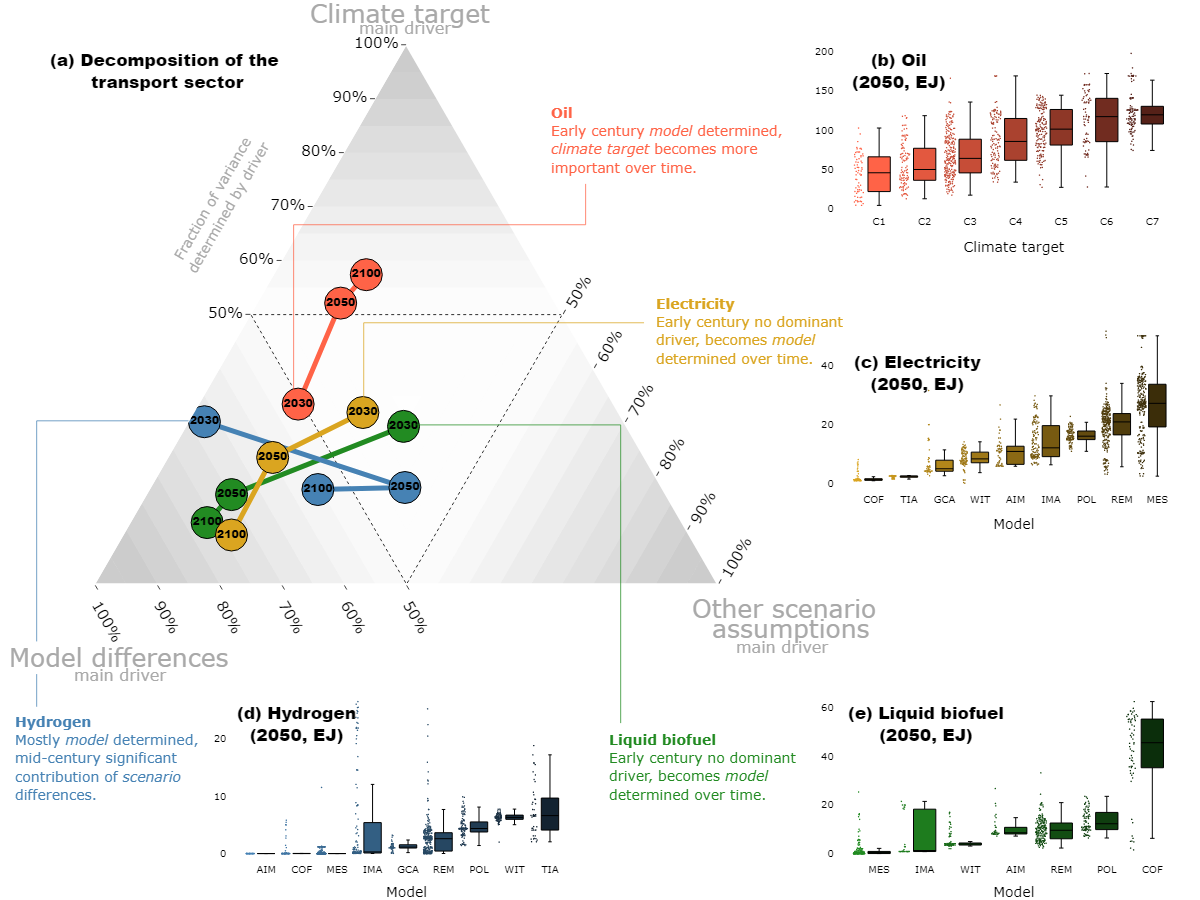

In [26]:
fig = make_subplots(
    rows=9, cols=6,
    horizontal_spacing = 0.04,
    vertical_spacing=0.02,
    specs = [[{"type": "scatterternary", "colspan": 4, "rowspan": 6}, {}, {}, {}, {"type": "box", "rowspan": 2, "colspan": 2}, {}],
             [{}, {}, {}, {}, {"type": "box", "rowspan": 2, "colspan": 2}, {}],
             [{}, {}, {}, {}, {}, {}],
             [{}, {}, {}, {}, {"type": "box", "rowspan": 2, "colspan": 2}, {}],
             [{}, {}, {}, {}, {"type": "box", "rowspan": 2, "colspan": 2}, {}],
             [{}, {}, {}, {}, {}, {}],
             [{}, {}, {}, {}, {"type": "box", "rowspan": 2, "colspan": 2}, {}],
             [{}, {"type": "box", "rowspan": 2, "colspan": 2}, {}, {}, {"type": "box", "rowspan": 2, "colspan": 2}, {}],
             [{}, {}, {}, {}, {}, {}]
            ],
    subplot_titles = ("", "", "",
                      "", "", title1,
                      "", "", "",
                      "", "", "",
                      "", "", title2,
                      "", "", "",
                      "", "", "",
                      title3, title4, "",
                      ),
)

# Lines 50%
fig.add_trace(go.Scatterternary(a=[0.5, 0.5, 0, 0.5], b=[0, 0.5, 0.5, 0], c=[0.5, 0, 0.5, 0.5],
                                                mode='lines',
                                                showlegend=False,
                                                hoverinfo='skip',
                                                marker={'size': 15,
                                                        'color': 'black',
                                                        'opacity': 1,#0.9-i*0.03,
                                                        'line' :dict(width=0., color=cl1)},
                                                line={'width': 1, #np.mean(s[i:i+2])*0.5,
                                                        'color': 'black',
                                                        'dash': 'dot'},
                                                textfont=dict(size=5,
                                                        color='black')), 1, 1)

# BOXPLOTS
for t_i, t in enumerate([t1, t2, t3, t4]):
        for i in range(len(t)):
                row = [1, 4, 8, 8][t_i]
                col = [5, 5, 5, 2][t_i]
                fig.add_trace(t[i], row, col)
                xlab = ['Climate target', 'Model', 'Model', 'Model'][t_i]
                fig.update_xaxes(title_text=xlab, row=row, col=col, title_font_size=14)

for n in range(len(conttraces)):
        fig.add_trace(conttraces[n], 1, 1)

for v in range(len(linetraces)):
        fig.add_trace(linetraces[v], 1, 1)
# for v in range(len(startraces)):
#         fig.add_trace(startraces[v], 1, 1)

fig.update_layout(height=900, width=1200)
fig.update_layout({'margin':dict(l=0,r=7,b=0,t=35),
'plot_bgcolor':'rgb(243, 243, 243)',
'ternary':
{'sum':1,
'bgcolor':'rgba(0,0,0,0)',#'whitesmoke',
    # "paper_bgcolor":'rgba(0,0,0,0)',
    # "plot_bgcolor":'rgba(0,0,0,0)',
'aaxis':{'title': '', 'min': 0, 'titlefont':{'size': 25},#Climate target<br>
        'linewidth':0, 'ticks':'outside',
        'tickmode':'array','tickvals':[0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'ticktext':['50%', '60%', '70%', '80%', '90%', '100%'], 'tickfont':{'size':15}},
'baxis':{'title': '', 'min': 0, 'titlefont':{'size': 25},# &nbsp; &nbsp; &nbsp;#Model &nbsp; &nbsp;
        'linewidth':2, 'ticks':'outside',
        'tickmode':'array','tickvals':[0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'ticktext':['50%', '60%', '70%', '80%', '90%', '100%'],'tickangle':60, 'tickfont':{'size':15}},
'caxis':{'title': '', 'min': 0, 'titlefont':{'size': 25},#Other<br>scenario assumptions
        'linewidth':2, 'ticks':'outside',
        'tickmode':'array','tickvals':[0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'ticktext':['50%', '60%', '70%', '80%', '90%', '100%'],'tickangle':-60, 'tickfont':{'size':15}}}})


fig.update_annotations(font_size=13)
#labels(fig)
#draw_lines(fig)
fig.update_layout(plot_bgcolor='rgba(0,0,0,0)')
args = dict(xref="paper", yref="paper", font=dict(color='black', family='Arial Black', size=17), showarrow=False)
for i in range(5):
    ex = ''
    if i >= 1: ex = "<br>(2050, EJ)"
    fig.add_annotation(text=['(a) Decomposition of the<br> transport sector',
                             '(b) Oil',
                             '(c) Electricity',
                             '(d) Hydrogen',
                             '(e) Liquid biofuel'][i]+ex, x=[0.02, 0.79, 0.82, 0.18, 0.84][i], y=[1, 1, 0.6, 0.14, 0.14][i], **args)

# CATEGORY TEXT
args = dict(xref="paper", yref="paper", showarrow=False)
fig.add_annotation(x=0.55,
                align='left',
                y=0.93,
                text='<b>Oil</b><br>Early century <i>model</i> determined,<br><i>climate target</i> becomes more<br>important over time.',
                font=dict(color='tomato', size=14), **args)
fig.add_annotation(x=0.62,
                align='left',
                y=0.65,
                text='<b>Electricity</b><br>Early century no dominant<br>driver, becomes <i>model</i><br>determined over time.',
                font=dict(color='goldenrod', size=14), **args)
fig.add_annotation(x=-0.01,
                align='left',
                y=0.07,
                text='<b>Hydrogen</b><br>Mostly <i>model</i> determined,<br>mid-century significant<br>contribution of <i>scenario</i><br>differences.',
                font=dict(color='steelblue', size=14), **args)
fig.add_annotation(x=0.58,
                align='left',
                y=0.07,
                text='<b>Liquid biofuel</b><br>Early century no dominant<br>driver, becomes <i>model</i><br>determined over time.',
                font=dict(color='forestgreen', size=14), **args)

# LINES TO TOTAL TEXTS
args = dict(xref='paper', yref='paper', type="line")
lw = 0.75
fig.add_shape(x0=0.23, y0=0.575, x1=0.23, y1=0.78, **args, line=dict(color="tomato",width=lw))
fig.add_shape(x0=0.48, y0=0.78, x1=0.23, y1=0.78, **args, line=dict(color="tomato",width=lw))
fig.add_shape(x0=0.48, y0=0.78, x1=0.48, y1=0.83, **args, line=dict(color="tomato",width=lw))

fig.add_shape(x0=0.29, y0=0.565, x1=0.29, y1=0.66, **args, line=dict(color="goldenrod",width=lw))
fig.add_shape(x0=0.53, y0=0.66, x1=0.29, y1=0.66, **args, line=dict(color="goldenrod",width=lw))

fig.add_shape(x0=0.335, y0=0.535, x1=0.51, y1=0.535, **args, line=dict(color="forestgreen",width=lw))
fig.add_shape(x0=0.51, y0=0.17, x1=0.51, y1=0.535, **args, line=dict(color="forestgreen",width=lw))

fig.add_shape(x0=0.14, y0=0.54, x1=0.01, y1=0.54, **args, line=dict(color="steelblue",width=lw))
fig.add_shape(x0=0.01, y0=0.27, x1=0.01, y1=0.54, **args, line=dict(color="steelblue",width=lw))
fig.add_shape(x0=0.01, y0=0.19, x1=0.01, y1=0.23, **args, line=dict(color="steelblue",width=lw))

# TRIANGLE CORNER LABELS
args = dict(xref="paper", yref="paper", showarrow=False)
fig.add_annotation(text="Climate target", x=0.242, y=1.06, **args, font=dict(color='darkgray', size=25))
fig.add_annotation(text="main driver", x=0.284, y=1.035, **args, font=dict(color='darkgray', size=16))
fig.add_annotation(text="Model differences", x=-0.015, y=0.23, **args, font=dict(color='darkgray', size=25))
fig.add_annotation(text="main driver", x=0.04, y=0.215, **args, font=dict(color='darkgray', size=16))
fig.add_annotation(text="Other scenario", x=0.73, y=0.29, **args, font=dict(color='darkgray', size=25))
fig.add_annotation(text="assumptions", x=0.725, y=0.265, **args, font=dict(color='darkgray', size=25))
fig.add_annotation(text="main driver", x=0.69, y=0.25, **args, font=dict(color='darkgray', size=16))

# AXIS ANNOTATIONS
args = dict(xref="paper", yref="paper", showarrow=False)
fig.add_annotation(text="Fraction of variance<br>determined by driver", x=0.12, y=0.9, textangle=-60, **args, font=dict(color='darkgray', size=14))

fig.update_layout(
    font=dict(
        size=10,
        color="black"
    )
)
fig.update_layout({'margin':dict(l=25,r=7,b=0,t=45)})
fig.show(renderer='png')

## Savings

In [28]:
if save == 1:
    try:
        os.remove('../Figures/Paperfigures/Figure_2.html')
    except:
        3
    def html_w(typ):
        return '<html> '+typ+' <p style="font-family: Arial">'

    fig.write_image("../Figures/Paperfigures/Figure_2.pdf")
    fig.write_image("../Figures/Paperfigures/Figure_2.svg")
    fig.write_image("../Figures/Paperfigures/Figure_2.png", scale=3)
    today = date.today()
    td = today.strftime("%B %d, %Y")

    with open('../Figures/Paperfigures/Figure_2.html', 'a') as f:
        f.write(html_w('<h1>')+'Figure 2 - Transport sector</p></h1>')
        f.write(html_w('<body>')+'Version: '+td+'</p></body>')
        f.write(fig.to_html(full_html=False, include_plotlyjs='cdn'))